# Projeto reconhecimento de padroes 
#### A. Noll, R. Salzmann and M.V. Wuthrich, Case Study: French Motor Third-Party Liability Claims (November 8, 2018).

------------------------------------------

In [3]:
from functools import partial
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.datasets import fetch_openml
from ydata_profiling import ProfileReport
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, model_selection, svm
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import f_regression, mutual_info_regression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from time import process_time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn_genetic import GAFeatureSelectionCV
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
#pip install -U dataprep
%matplotlib inline

## Tratamento dos dados [ETL]

In [4]:
# Base Freq
df_freq = fetch_openml(data_id=41214, as_frame=True).data
df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_freq.set_index("IDpol", inplace=True)

In [5]:
#Base indenizacao
df_sev = fetch_openml(data_id=41215, as_frame=True).data
df_sev = df_sev.groupby("IDpol").sum()

In [6]:
#Juntando a base
df = df_freq.join(df_sev, how="left")
df["ClaimAmount"] = df["ClaimAmount"].fillna(0)

In [7]:
# Campos de string sem aspas
n_samples=None
for column_name in df.columns[[t is object for t in df.dtypes.values]]:
    df[column_name] = df[column_name].str.strip("'")
    #return df.iloc[:n_samples]

In [8]:
df["target"] = df["ClaimNb"].apply(lambda x: 1 if x > 0 else 0)

In [9]:
# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)
# If the claim amount is 0, then we do not count it as a claim. The loss function
# used by the severity model needs strictly positive claim amounts. This way
# frequency and severity are more consistent with each other.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

In [10]:
#Auxiliar
#X = resample(df, random_state=0, n_samples = 30000, stratify=df['target'])

In [11]:
#Pre-Processamento / Inicializando objetos
scaler = StandardScaler()
enc = OrdinalEncoder()
#MinMax = MinMaxScaler()

In [12]:
#Codificacao para aplicar Correlacoes
df[['Area','VehBrand','VehGas','Region']] = enc.fit_transform( df[['Area','VehBrand','VehGas','Region']] )

In [13]:
#Separa X/Y e remove leakage
ListaX = ['Area', 'VehPower', 'VehAge', 'DrivAge','BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']

X = df[ListaX]#.values
y = df['target']

## Analise Exploratoria

In [ ]:
#df.dtypes
#Tipo das variaveis e descricao

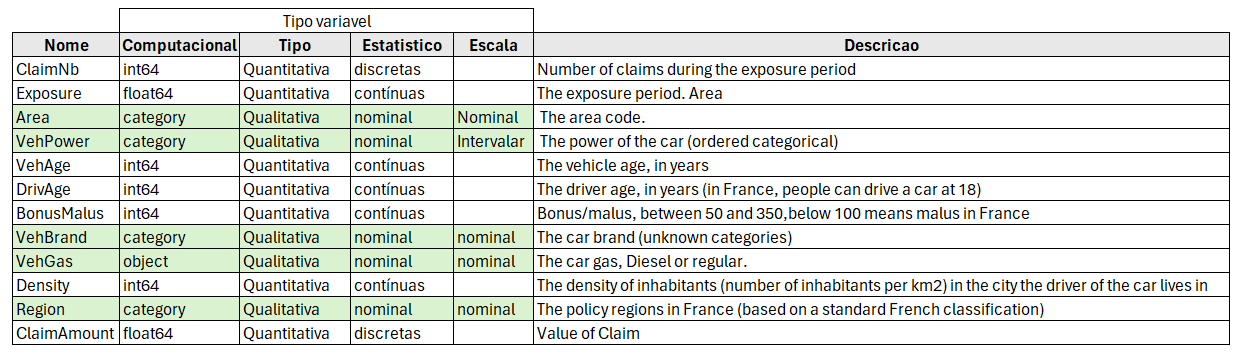

In [9]:
#df.to_excel("df.xlsx")  
df.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,target
IDpol,,,,,,,,,,,,,
1,1,0.10,D,5,0,55,50,B12,'Regular',1217,R82,0.0,1
3,1,0.77,D,5,0,55,50,B12,'Regular',1217,R82,0.0,1
5,1,0.75,B,6,2,52,50,B12,'Diesel',54,R22,0.0,1
10,1,0.09,B,7,0,46,50,B12,'Diesel',76,R72,0.0,1
11,1,0.84,B,7,0,46,50,B12,'Diesel',76,R72,0.0,1


In [7]:
#Descricao estatistica geral
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,target
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01,0.050235
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03,0.218430
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.000000


In [225]:
# Sinsitrado representa 5%, e 5.3% sobre a classe maior
df.groupby('target')['target'].agg(['count'])

,count
target,
0,643953
1,34060


<Axes: xlabel='VehGas'>

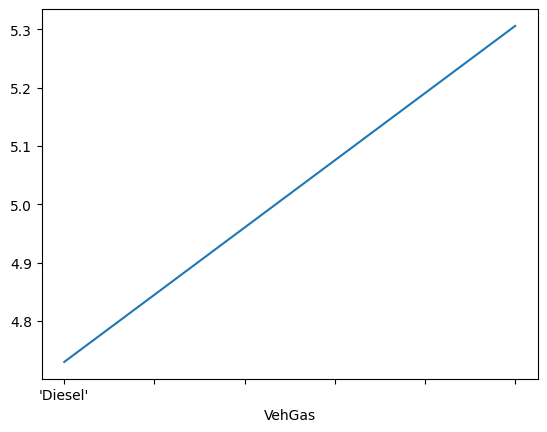

In [8]:
#Analise do risco em funcao dos fatores de risco.
#'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 
#Eixo Y - variavel Resposta / Eixo X - variavel categorica
a = df.groupby('VehGas')['target'].agg(['sum','count'])
b = a['sum'] / a['count'] *100
b.plot(kind = 'line')

In [ ]:
#Gera graficos dinamicoss, mas e oneroso e essas analises ja estao na apresentacao atual.
profile = ProfileReport(df, title="Profiling Report", explorative=True)
profile

In [ ]:
#Esta no excel esta matriz de graficos
sns.pairplot(X, hue = 'target' , diag_kind= 'hist', plot_kws=dict(alpha=0.5), diag_kws=dict(alpha=0.5)) 

### Correlacao

<Axes: >

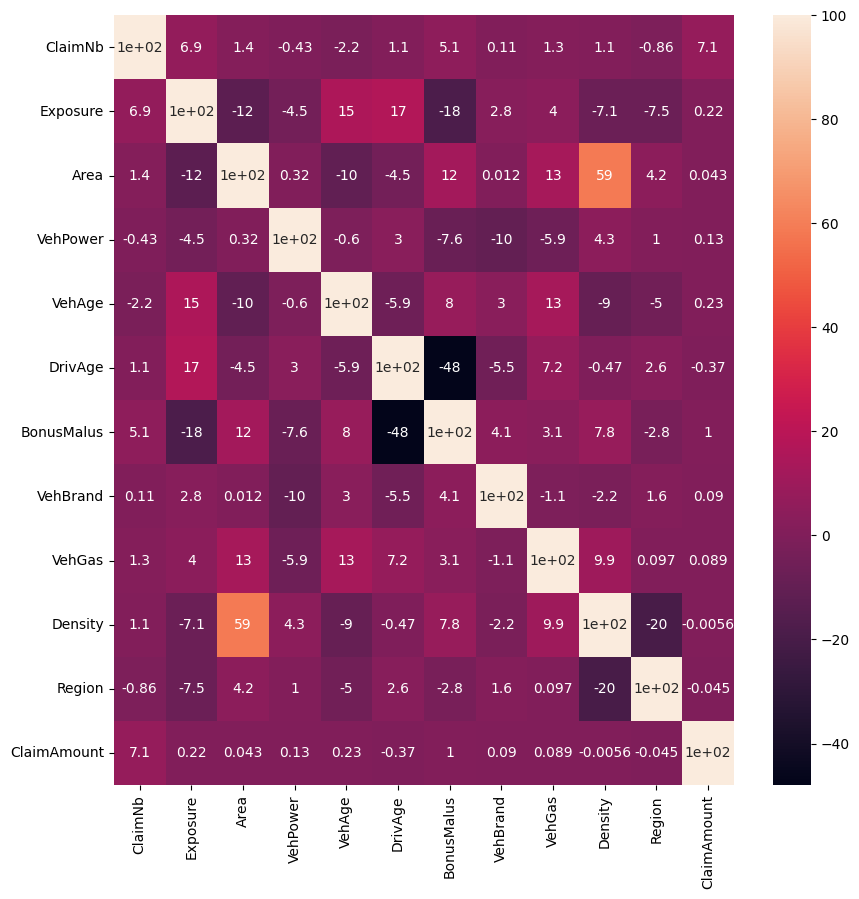

In [42]:
 #‘kendall’, ‘spearman’,'pearson'
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df.corr(method='pearson')*100, annot = True, ax = ax )

----------------------------------------------------------------

# PCA

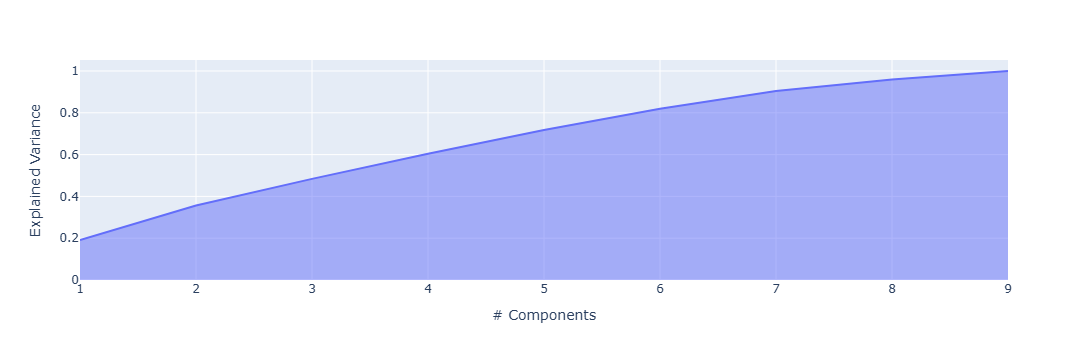

In [92]:
#Escolher 7 PC
pca = PCA()
pca.fit( scaler.fit_transform(df[Lista])  )
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

## Feature Selection

### Filtro

In [ ]:
# Calculando F test & Mutual information 
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

In [54]:
#Mutual infomation - mi
print(mi*100)

[ 14.6066867    0.         100.          13.44847811  95.44275659
   8.28682238  15.79163798  12.22595265   0.        ]


In [55]:
#Medida F-Test
print(f_test*100)

[  6.12653219   0.63678212  20.04147264   6.06734033 100.
   0.17674322   7.1998949    4.24634153   4.58445634]


## Wrapper

In [29]:
#Gerei esse split para ter uma base quase inteira por que alguns algoritmos fazem o CrossVal internamento.
X_train, X_test, y_train, y_test = train_test_split( scaler.fit_transform(df[ListaX]), y, test_size=0.01, random_state=42)

#Escolhe a arvore de decisao por que a logistica tem um vies estranho dado a caracteristica alta de evento raro e invariava resultado 
#em detrimento de qualquer variavel, o KNN e muito pesado para base com muitas instancias.

#### Sequencial Forward Selection

In [30]:
# Set up SFS parameters
sfs = SFS(clf,
          k_features='parsimonious', # number of features to select
          forward=True,
          floating=True,
          scoring='f1',
          cv=5,
         n_jobs = -2,
         verbose = 2)
sfs.fit( X_train , y_train  )

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of   9 | elapsed:    5.9s remaining:   12.0s
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:   10.4s finished

[2024-10-12 19:19:43] Features: 1/9 -- score: 5.9276822762299933e-05[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   8 | elapsed:    9.8s remaining:   29.7s
[Parallel(n_jobs=-2)]: Done   8 out of   8 | elapsed:   12.1s finished

[2024-10-12 19:19:55] Features: 2/9 -- score: 0.03283043876749472[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   7 | elapsed:   11.3s remaining:   28.5s
[Parallel(n_jobs=-2)]: Done   7 out of   7 | elapsed:   13.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:    5.2s finished

[2024-10-12 19:20:14] Feature

SequentialFeatureSelector(estimator=DecisionTreeClassifier(random_state=0),
                          floating=True, k_features=(1, 9), n_jobs=-2,
                          scoring='f1', verbose=2)

In [34]:
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
sfs.subsets_

(0, 1, 2, 3, 4, 5, 6, 7)
('0', '1', '2', '3', '4', '5', '6', '7')


{1: {'feature_idx': (7,),
  'cv_scores': array([0.        , 0.        , 0.        , 0.00029638, 0.        ]),
  'avg_score': np.float64(5.9276822762299933e-05),
  'feature_names': ('7',)},
 2: {'feature_idx': (3, 7),
  'cv_scores': array([0.02998909, 0.0335882 , 0.0343184 , 0.02916896, 0.03708754]),
  'avg_score': np.float64(0.03283043876749472),
  'feature_names': ('3', '7')},
 3: {'feature_idx': (2, 3, 7),
  'cv_scores': array([0.10914341, 0.11274556, 0.11507634, 0.1165568 , 0.11758023]),
  'avg_score': np.float64(0.11422046733919906),
  'feature_names': ('2', '3', '7')},
 4: {'feature_idx': (1, 2, 3, 7),
  'cv_scores': array([0.1495102 , 0.15101202, 0.14886731, 0.14800095, 0.14873266]),
  'avg_score': np.float64(0.1492246293539088),
  'feature_names': ('1', '2', '3', '7')},
 5: {'feature_idx': (1, 2, 3, 5, 7),
  'cv_scores': array([0.15815938, 0.162739  , 0.15916903, 0.15552359, 0.15533248]),
  'avg_score': np.float64(0.15818469407429092),
  'feature_names': ('1', '2', '3', '5', '7'

('0', '1', '2', '3', '4', '5', '6', '7')
0.1634994892929133


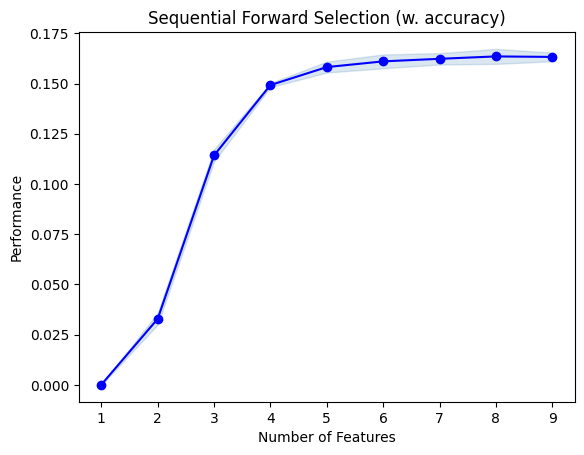

In [31]:
# first let's print the chosen features names
#Escolha sfs 1, 2, 3, 7
print(sfs.k_feature_names_)

# print the accuracy of the model after sequential forward selection
print(sfs.k_score_)

# plot the model accuracy
plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection (w. accuracy)')
plt.show()

#### Sequencial Backward Selection

In [32]:

# Set up SFS parameters
sbs = SFS(clf,
          k_features='parsimonious', # number of features to select
          forward=False,
          floating=True,
          scoring='f1',
          cv=5,
         n_jobs = -2,
         verbose = 2)
sbs.fit( X_train , y_train  )

C:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of   9 | elapsed:   29.1s remaining:   58.3s
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:   30.8s finished

[2024-10-12 19:36:42] Features: 8/1 -- score: 0.1634994892929133[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   8 | elapsed:   22.2s remaining:  1.1min
[Parallel(n_jobs=-2)]: Done   8 out of   8 | elapsed:   25.1s finished

[2024-10-12 19:37:08] Features: 7/1 -- score: 0.16230909988509246[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   7 | elapsed:   18.2s remaining:   45.7s
[Para

SequentialFeatureSelector(estimator=DecisionTreeClassifier(random_state=0),
                          floating=True, forward=False, k_features=(1, 9),
                          n_jobs=-2, scoring='f1', verbose=2)

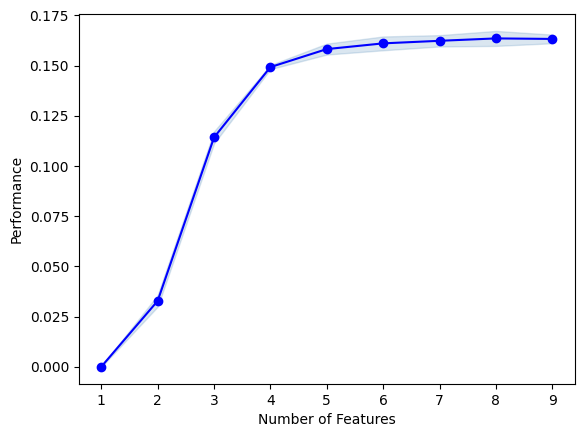

In [35]:
plot_sfs(sbs.get_metric_dict())
plt.show()

In [36]:
print(sbs.k_feature_idx_)
print(sbs.k_feature_names_)
sbs.subsets_

(0, 1, 2, 3, 4, 5, 6, 7)
('0', '1', '2', '3', '4', '5', '6', '7')


{9: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8),
  'cv_scores': array([0.15954828, 0.16397147, 0.16576602, 0.16230105, 0.16461374]),
  'avg_score': np.float64(0.16324011293583737),
  'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7', '8')},
 8: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7),
  'cv_scores': array([0.16036853, 0.16926376, 0.16562478, 0.16343251, 0.15880786]),
  'avg_score': np.float64(0.1634994892929133),
  'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7')},
 7: {'feature_idx': (1, 2, 3, 4, 5, 6, 7),
  'cv_scores': array([0.15814489, 0.16455787, 0.16527417, 0.16378066, 0.1597879 ]),
  'avg_score': np.float64(0.16230909988509246),
  'feature_names': ('1', '2', '3', '4', '5', '6', '7')},
 6: {'feature_idx': (1, 2, 3, 5, 6, 7),
  'cv_scores': array([0.1623533 , 0.16600266, 0.16252024, 0.15678347, 0.15750751]),
  'avg_score': np.float64(0.16103343365887807),
  'feature_names': ('1', '2', '3', '5', '6', '7')},
 5: {'feature_idx': (1, 2, 3, 5, 7),
  'cv_scores': array

#### Recursive Feature Elimination

[False  True  True  True False False False  True False]
[6 1 1 1 2 3 5 1 4]
0.9186151698098366
9
0.912214115749936


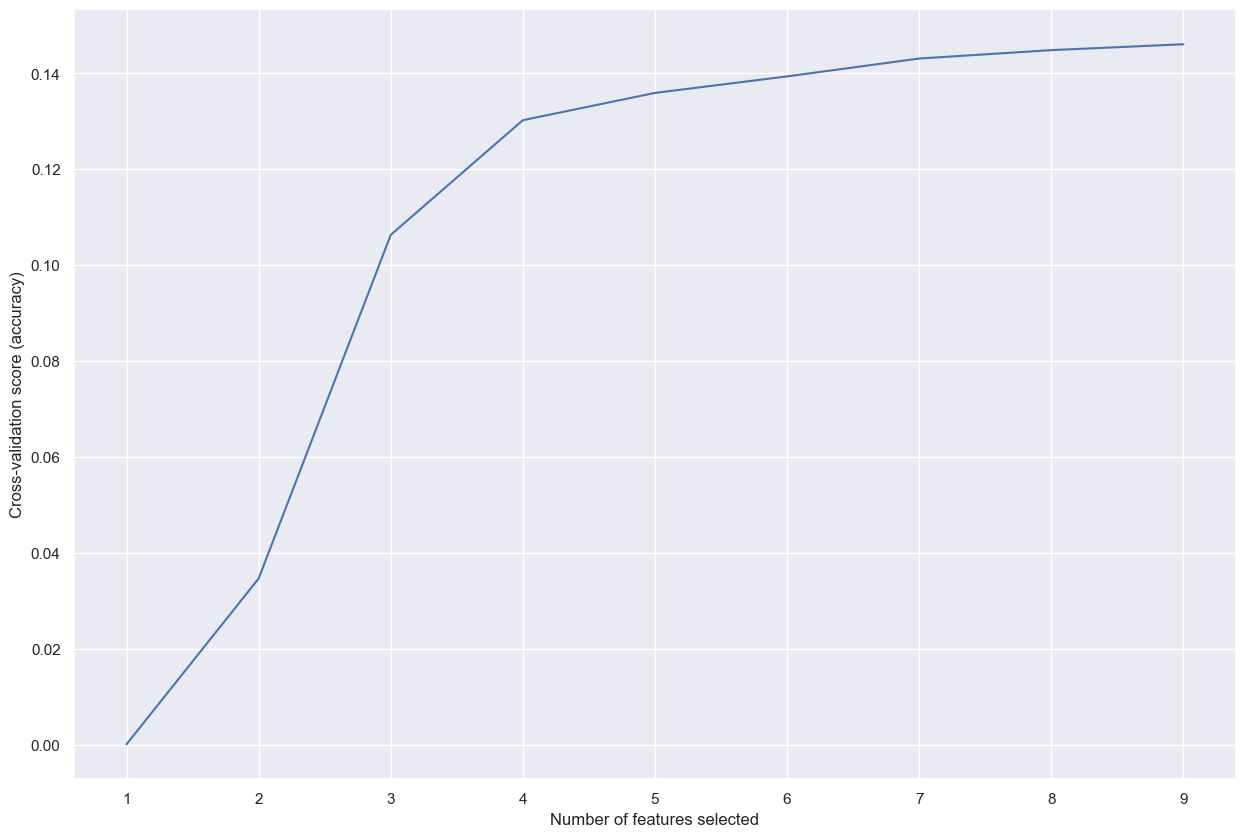

In [111]:
rfe = RFE(estimator=clf, n_features_to_select=4)
, , , 
# Fit the model
rfe.fit(X_train, y_train)

# Print the features 
print(rfe.support_)

# Print the ranking
print(rfe.ranking_)

# Print the accuracy of the model
print(rfe.score(X_test, y_test))


# visualize the performance of the model as a function of the number of features
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='f1')
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print(rfecv.n_features_)
# Print the accuracy of the model
print(rfecv.score(X_test, y_test))

# Visualize the performance of the model as a function of the number of features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()
#colunas 2,3,4,8

#### Algoritmo Genetico

In [112]:
evolved_estimator = GAFeatureSelectionCV(
    estimator=clf, #algoritmo e arvore de decisao
    cv=3,          # 3 folds de crossval
    scoring="f1",  #Meda e F1 score
    population_size=30, #quantidade de cromossomos
    generations=1000,   # quantiodades de geracoes/novas mutacoes
    n_jobs=-2,          # usar todos os cores do CPU deixando um disponivel
    verbose=True,       # Gerar log
    keep_top_k=10,      #em cada geracao manter pelo menos 10 dos melhores sem sofrer mutacoes
    elitism=True,       #permite item acima
    crossover_probability = 0.1, #recombinacao dos cromossomos
    mutation_probability = 0.9   #mtacao dos alelos do cromossomo
)

In [208]:
#Aqui eu fiz um split coerente pq o GA requer essa configuracao
X_train, X_test, y_train, y_test = train_test_split( scaler.fit_transform(X), y, test_size=0.30, random_state=42, stratify = y)

In [113]:
evolved_estimator.fit(X_train, y_train)
features = evolved_estimator.support_

# Predict only with the subset of selected features
y_predict_ga = evolved_estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_predict_ga)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.037291	0.0422243  	0.132072   	0          
1  	60    	0.102372	0.0250348  	0.135894   	0.042944   
2  	60    	0.0975972	0.0371507  	0.135894   	0.00613779 
3  	60    	0.0998516	0.0360428  	0.135894   	0.0106295  
4  	60    	0.0991957	0.0421554  	0.135894   	0.00125084 
5  	60    	0.121643 	0.0139865  	0.135894   	0.084092   
6  	60    	0.113141 	0.0326174  	0.135894   	0.00125084 
7  	60    	0.105199 	0.0411795  	0.135894   	0.000835799
8  	60    	0.104709 	0.0399113  	0.135894   	0.00125084 
9  	60    	0.103227 	0.0353907  	0.135894   	0.0066712  
10 	60    	0.100208 	0.0356682  	0.135894   	0.0340996  
11 	60    	0.100156 	0.0360225  	0.135894   	0.00125084 
12 	60    	0.106123 	0.0251855  	0.135894   	0.0403045  
13 	60    	0.103786 	0.0396944  	0.135894   	0.0066712  
14 	60    	0.0955742	0.0421406  	0.132263   	0          
15 	60    	0.0961156	0.0447411  	0.132263   	0.000250794
16 	60    	0.101837 	0.0361708  	0

In [147]:
#Best features found
print(evolved_estimator.best_features_)
print(evolved_estimator.support_)
print("accuracy score: ", "{:.2f}".format(accuracy))

[False  True  True  True  True  True  True  True False]
[False  True  True  True  True  True  True  True False]
accuracy score:  0.91


In [138]:
#Best features found
print(evolved_estimator.support_)
y_pred = evolved_estimator.predict(X_test) 

print("F1 Score: ", "{:.3f}".format( f1_score(y_test, y_pred, average=None)[1] ))
#2,3,4,5,6,7,8

[False  True  True  True  True  True  True  True False]
F1 Score:  0.157


C:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


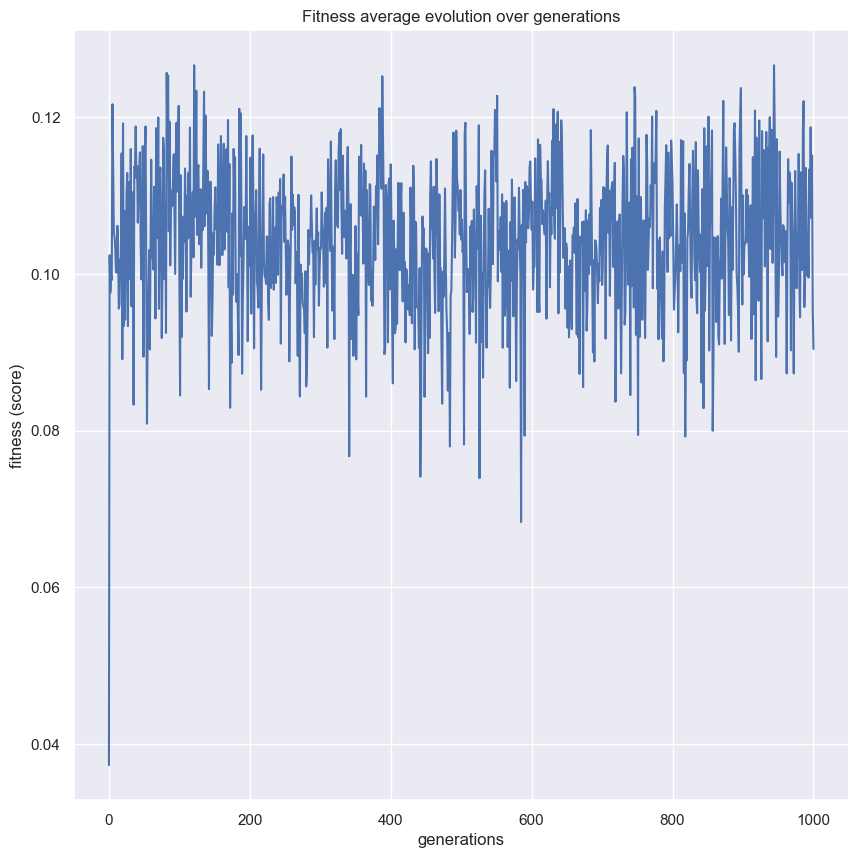

In [122]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")
plt.show()

### Embutidos

In [38]:
start = process_time()
clf = DecisionTreeClassifier(random_state=0).fit( X_train , y_train ) 
end = process_time()

clf.score( X_test ,  y_test )
print(end - start)

-3.53125


In [105]:
feature_importances = clf.feature_importances_
feature_importances

array([0.01831532, 0.10019078, 0.17702024, 0.24541932, 0.07560246,
       0.03781674, 0.28405453, 0.06158062])

#### feature importances

<Axes: >

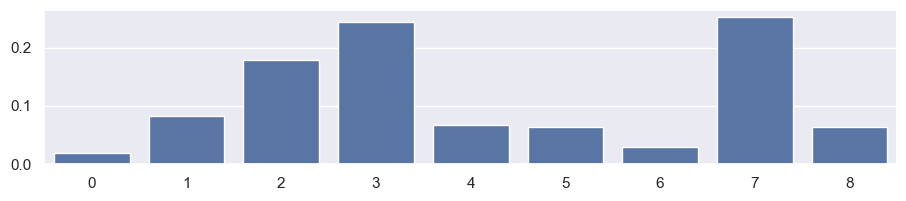

In [52]:
# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11,2)})
sns.barplot(feature_importances)

#### permutation_importance

In [54]:
result = permutation_importance( clf,  X_test ,  y_test, n_repeats=10, random_state=42, n_jobs=2 )
forest_importances = pd.Series(result.importances_mean)

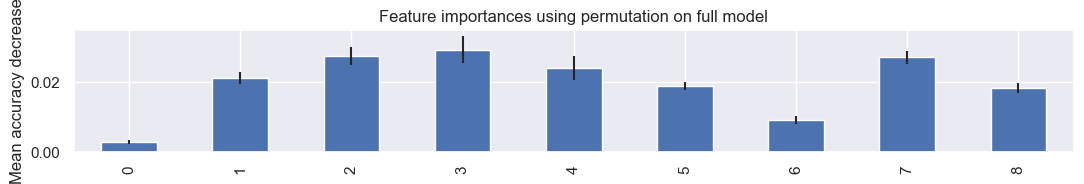

In [55]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

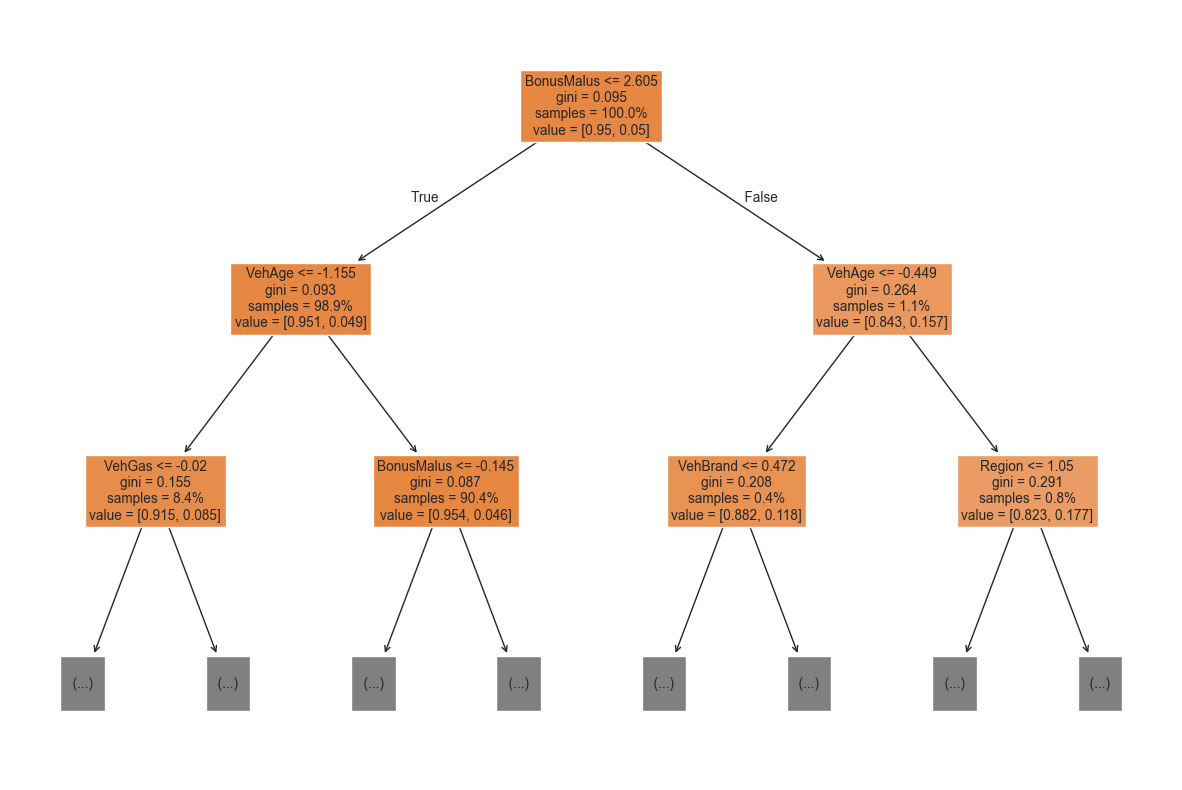

In [86]:
#Gerar a estrutura da arvore e criterios de impureza para split das folhas, este plot apoia na interpretabilidade
sns.set(rc={'figure.figsize':(15,10)}) 
tree.plot_tree(clf, proportion=True, max_depth = 2, feature_names = df[ListaX].columns, filled = True )
#plt.savefig('out.pdf') 
plt.show()

-------------------------------------

# Modelagem

#### Preparando bases

In [327]:
#Para definicao das tres bases, o PCA eu selecionei 7, removi dois para trazer um desafio, sendo que os dois ultimos nao apresentam uma variancia explicada significativa.
#Para selecao de features, nos filtros eu preciso estudar mais para entender melhor decisaom, em wrapper o sfs/sbs/rfe fizeram as mesmas sugestoes.
#Ainda no wrapper, o GA apresentou um selecao similar ao metodo imbutido similar a feature permuation exceto por uma variavel, mas optei por seguir no GA original para eliminar vies de preferencia.
listGA = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density']
listSFS = ['VehPower', 'VehAge', 'DrivAge','Density']
pca = PCA(n_components = 7)

df_pca = pca.fit_transform( scaler.fit_transform(X) )
df_GA = X[listGA]
df_SFS = X[listSFS]

### Naive Bayes

In [328]:
X_train, X_test, y_train, y_test = train_test_split( scaler.fit_transform(X), y, test_size=0.30, random_state=42, stratify = y)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( df_pca, y, test_size=0.30, random_state=42, stratify = y)
X_train_GA, X_test_GA, y_train_GA, y_test_GA = train_test_split( scaler.fit_transform(df_GA), y, test_size=0.30, random_state=42, stratify = y)
X_train_SFS, X_test_SFS, y_train_SFS, y_test_SFS = train_test_split( scaler.fit_transform(df_SFS), y, test_size=0.30, random_state=42, stratify = y)
#X_train, X_test, y_train, y_test = train_test_split( scaler.fit_transform(X_res), y_res, test_size=0.30, random_state=42, stratify = y_res)

In [329]:
#Medidas para avaliar no GridSearch
scoring = ['accuracy', 'precision', 'recall', 'f1' , 'roc_auc']
#Hiperparametros do naive bayes
param={'var_smoothing': [0.00001, 0.0001, 0.001, 0.1, 1, 0.00000000000001,1000]}

Model_grid = GridSearchCV( estimator=GaussianNB(), param_grid = param , verbose=3, cv=10, n_jobs=-2, return_train_score = True, 
                          scoring = scoring, refit = 'f1')

In [330]:
Model_grid.fit(X_train, y_train )

print(Model_grid.score(X_test,y_test) )
print(Model_grid.best_estimator_)

Model_grid_results = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results.insert(0, "df_Feature", 'Original', True)
best_grid = Model_grid.best_params_ 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
0.03354472630173565
GaussianNB(var_smoothing=1e-14)


In [331]:
Model_grid.fit(X_train_pca, y_train_pca )

print(Model_grid.score(X_test_pca, y_test_pca) )
print(Model_grid.best_estimator_)

Model_grid_results_pca = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_pca.insert(0, "df_Feature", 'PCA', True)
best_grid_pca = Model_grid.best_params_ 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
0.00019565642731363725
GaussianNB(var_smoothing=1e-05)


In [332]:
Model_grid.fit(X_train_GA, y_train_GA )

print(Model_grid.score(X_test_GA,y_test_GA) )
print(Model_grid.best_estimator_)

Model_grid_results_GA = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_GA.insert(0, "df_Feature", 'GA', True)
best_grid_GA = Model_grid.best_params_ 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
0.029907184599518737
GaussianNB(var_smoothing=1e-05)


In [333]:
Model_grid.fit(X_train_SFS, y_train_SFS )

print(Model_grid.score(X_test_SFS,y_test_SFS) )
print(Model_grid.best_estimator_)

Model_grid_results_SFS = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_SFS.insert(0, "df_Feature", 'SFS', True)
best_grid_SFS = Model_grid.best_params_ 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
0.004356473150866559
GaussianNB(var_smoothing=0.0001)


In [334]:
#grid_list = {0: "Alvo", }   rename(columns={0: "Alvo"})
#df.style.format({"B": lambda x: "±{:.2f}".format(abs(x))})
metrics_column = ['df_Feature', 'mean_test_accuracy','std_test_accuracy', 'mean_test_precision','std_test_precision', 'mean_test_recall','std_test_recall', 'mean_test_f1','std_test_f1', 'mean_test_roc_auc','std_test_roc_auc']
res = Model_grid_results.loc[ Model_grid_results["params"] == best_grid  ][metrics_column]#.style.format('{:.2%}')
res_pca = Model_grid_results_pca.loc[ Model_grid_results_pca["params"] == best_grid_pca  ][metrics_column]#.style.format('{:.2%}')
res_GA = Model_grid_results_GA.loc[ Model_grid_results_GA["params"] == best_grid_GA  ][metrics_column]#.style.format('{:.2%}')
res_SFS = Model_grid_results_SFS.loc[ Model_grid_results_SFS["params"] == best_grid_SFS  ][metrics_column]#.style.format('{:.2%}')

Resultado_bayes = pd.concat([res, res_pca, res_GA, res_SFS])#.style.format('{:.2}')
Resultado_bayes

,df_Feature,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc
5,Original,0.941836,0.002523,0.110738,0.028100,0.020762,0.001730,0.034703,0.003390,0.567240,0.007737
0,PCA,0.949759,0.000014,0.050000,0.150000,0.000042,0.000126,0.000084,0.000251,0.549914,0.006734
0,GA,0.943836,0.001518,0.121761,0.029573,0.017993,0.002174,0.031258,0.004209,0.566177,0.008272
1,SFS,0.946099,0.003381,0.049138,0.033282,0.004446,0.004371,0.007728,0.007312,0.535463,0.006796


In [566]:
#Gera insumos para avaliar a sensibilidade por limiares diversos

prob = pd.DataFrame(Model_grid.best_estimator_.predict_proba(X_test))
recall = []

for n in np.arange(0.01,0.99,0.01):
    prob['y_pred'] = prob[1].apply(lambda x: 1 if x > n else 0)
    recall.append( recall_score(y_test, prob['y_pred'] ) )

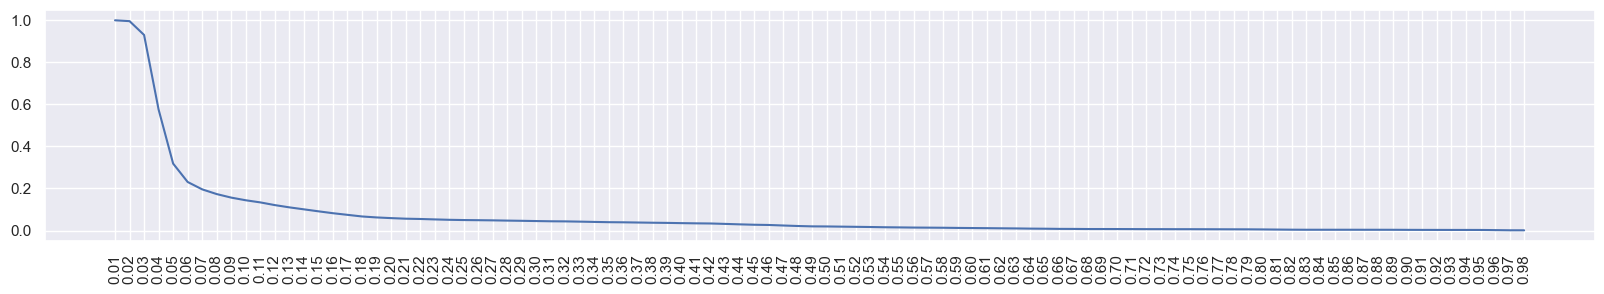

In [578]:
#Plot sensibilidade por limiares e identificar ponto otimo.
fig, ax = plt.subplots(1,1 ,figsize=(20,3)) 
plt.plot(np.arange(0.01,0.99,0.01), recall)
plt.xticks( np.arange(0.01,0.99,0.01) ) 
plt.xticks(rotation=90)
plt.show()

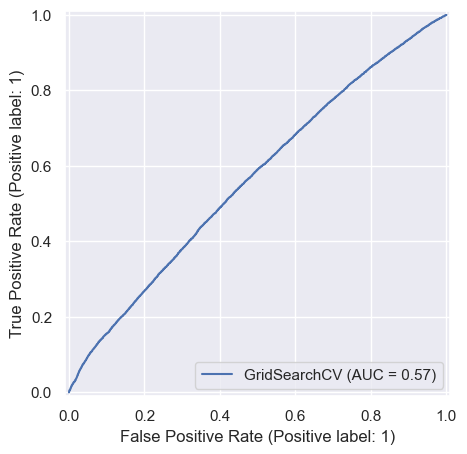

In [538]:
#Curva ROC
fig, ax = plt.subplots(1,1 ,figsize=(10,5)) 
RocCurveDisplay.from_estimator(  Model_grid, X_test, y_test, ax=ax)
plt.show()

In [643]:
#Todos os resultados  
Model_grid.cv_results_

{'mean_fit_time': array([0.49876595, 0.45905418, 0.45763443, 0.48854561, 0.48508296,
        0.48171868, 0.46108057]),
 'std_fit_time': array([0.01630428, 0.02267088, 0.02745894, 0.01947839, 0.02088291,
        0.01400199, 0.05131217]),
 'mean_score_time': array([0.1720309 , 0.1676347 , 0.17309089, 0.18001795, 0.18049562,
        0.17434649, 0.17255743]),
 'std_score_time': array([0.01396951, 0.02069455, 0.01984108, 0.02561506, 0.02500647,
        0.01674633, 0.05508713]),
 'param_var_smoothing': masked_array(data=[1e-05, 0.0001, 0.001, 0.1, 1.0, 1e-14, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'var_smoothing': 1e-05},
  {'var_smoothing': 0.0001},
  {'var_smoothing': 0.001},
  {'var_smoothing': 0.1},
  {'var_smoothing': 1},
  {'var_smoothing': 1e-14},
  {'var_smoothing': 1000}],
 'split0_test_accuracy': array([0.93925539, 0.93925539, 0.93936074, 0.94507069, 0.94970607,
        0.93925539, 0.94976928]),
 'split

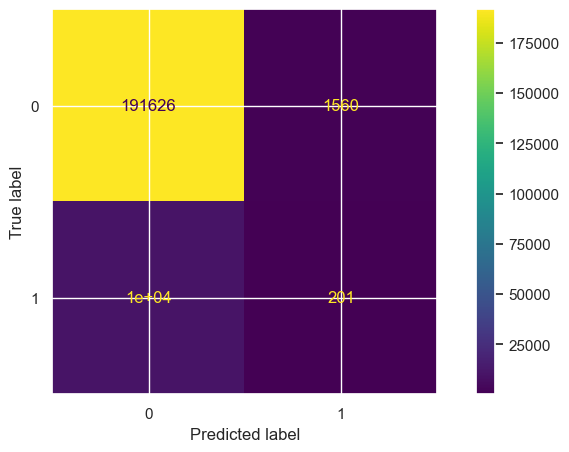

In [522]:
#Matriz de confusao
fig, ax = plt.subplots(1,1 ,figsize=(10,5)) 

predictions = Model_grid.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=Model_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = clf.classes_)

disp.plot(ax=ax)
plt.show()

In [524]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=Model_grid.classes_).ravel() 
(tn, fp, fn, tp)

(np.int64(191626), np.int64(1560), np.int64(10017), np.int64(201))

Resampled dataset shape Counter({np.int64(0): 10218, np.int64(1): 10218})


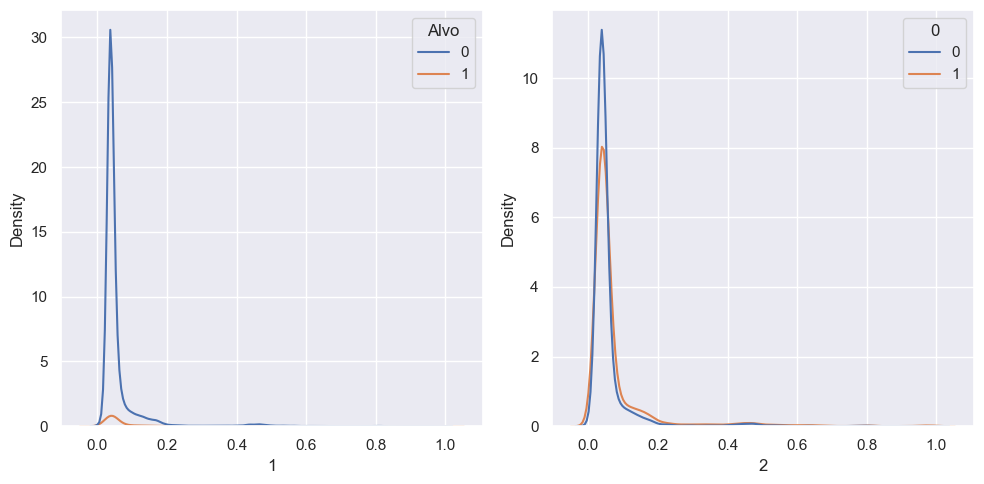

In [537]:
#Instancio o objeto de undersampling para fazer ajuste de patamar nas distribuicoes
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

#Gero as bases com as probabilidades para cada classe
output = pd.DataFrame(y_test.values).rename(columns={0: "Alvo"}).join(pd.DataFrame(Model_grid.best_estimator_.predict_proba(X_test)), how="left")
X_resampled, y_X_resampled = rus.fit_resample(  output.values , pd.DataFrame(output)['Alvo'].values )
print('Resampled dataset shape %s' % Counter(y_X_resampled))

#Gero plot para avaliar a diferenca de distribuicao entre as classes, isso ajuda a encontrar um limiar e avalair a qualidade do classificador 
fig, axes = plt.subplots(1,2, figsize=(10,5))

#Plot da base teste original
sns. kdeplot(output, x=1, hue="Alvo" , ax = axes[0])
#Plot com a base teste com a classe majoritaria reduzida
sns. kdeplot( pd.DataFrame(y_X_resampled), x=pd.DataFrame(X_resampled)[2], hue=0,  ax = axes[1])

plt.tight_layout()
plt.show()

----------------

### SVM - Support Vector Machine

In [335]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.utils import resample
#C - Quanto menor, maior a margem e maior tolerancia a classificacao errada
#gamma - quanto menor, maior o range de distancia considerado para computar os pontos a decisao de fronteira
# 

In [336]:
df_pca,  y_pca = resample( df_pca, y, replace = False, random_state=0, stratify = y , n_samples = 30000)
X,  y = resample( X, y, replace = False, random_state=0, stratify = y , n_samples = 30000)

In [337]:
X_train, X_test, y_train, y_test = train_test_split( scaler.fit_transform(X), y, test_size=0.30, random_state=42, stratify = y)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( df_pca, y_pca, test_size=0.30, random_state=42, stratify = y)
X_train_GA, X_test_GA, y_train_GA, y_test_GA = train_test_split( scaler.fit_transform(X[listGA]), y, test_size=0.30, random_state=42, stratify = y)
X_train_SFS, X_test_SFS, y_train_SFS, y_test_SFS = train_test_split( scaler.fit_transform(X[listSFS]), y, test_size=0.30, random_state=42, stratify = y)
#X_train, X_test, y_train, y_test = train_test_split( scaler.fit_transform(X_res), y_res, test_size=0.30, random_state=42, stratify = y_res)

In [344]:
#Medidas para avaliar no GridSearch
scoring = ['accuracy', 'precision', 'recall', 'f1' , 'roc_auc']
#Hiperparametros do naive bayes
#param={ 'var_smoothing': [  1 ] }
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf'], 'class_weight': ['balanced'], 'probability' : [True]} 

Model_grid = GridSearchCV( estimator=SVC(), param_grid = param_grid , verbose=3, cv=2, n_jobs=-2, return_train_score = True, 
                          scoring = scoring, refit = 'f1')

In [345]:
Model_grid.fit(X_train, y_train )

print(Model_grid.score(X_test,y_test) )
print(Model_grid.best_estimator_)
#cache_size
Model_grid_results = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results.insert(0, "df_Feature", 'Original', True)
best_grid = Model_grid.best_params_ 

Fitting 2 folds for each of 49 candidates, totalling 98 fits
0.11538461538461539
SVC(C=0.1, class_weight='balanced', gamma=0.01, probability=True)


In [346]:
#Model_grid.cv_results_
print(Model_grid.best_estimator_)

SVC(C=0.1, class_weight='balanced', gamma=0.01, probability=True)


In [347]:
Model_grid.fit(X_train_pca, y_train_pca )

print(Model_grid.score(X_test_pca, y_test_pca) )
print(Model_grid.best_estimator_)

Model_grid_results_pca = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_pca.insert(0, "df_Feature", 'PCA', True)
best_grid_pca = Model_grid.best_params_ 

Fitting 2 folds for each of 49 candidates, totalling 98 fits
0.1092001092001092
SVC(C=1000, class_weight='balanced', gamma=0.001, probability=True)


In [348]:
Model_grid.fit(X_train_GA, y_train_GA )

print(Model_grid.score(X_test_GA,y_test_GA) )
print(Model_grid.best_estimator_)

Model_grid_results_GA = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_GA.insert(0, "df_Feature", 'GA', True)
best_grid_GA = Model_grid.best_params_ 

Fitting 2 folds for each of 49 candidates, totalling 98 fits
0.11588111678174723
SVC(C=10, class_weight='balanced', gamma=0.1, probability=True)


In [349]:
Model_grid.fit(X_train_SFS, y_train_SFS )

print(Model_grid.score(X_test_SFS,y_test_SFS) )
print(Model_grid.best_estimator_)

Model_grid_results_SFS = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_SFS.insert(0, "df_Feature", 'SFS', True)
best_grid_SFS = Model_grid.best_params_ 

Fitting 2 folds for each of 49 candidates, totalling 98 fits
0.10326499620349279
SVC(C=100, class_weight='balanced', gamma=0.1, probability=True)


In [350]:
#grid_list = {0: "Alvo", }   rename(columns={0: "Alvo"})
#df.style.format({"B": lambda x: "±{:.2f}".format(abs(x))})
metrics_column = ['df_Feature', 'mean_test_accuracy','std_test_accuracy', 'mean_test_precision','std_test_precision', 'mean_test_recall','std_test_recall', 'mean_test_f1','std_test_f1', 'mean_test_roc_auc','std_test_roc_auc']
res = Model_grid_results.loc[ Model_grid_results["params"] == best_grid  ][metrics_column]#.style.format('{:.2%}')
res_pca = Model_grid_results_pca.loc[ Model_grid_results_pca["params"] == best_grid_pca  ][metrics_column]#.style.format('{:.2%}')
res_GA = Model_grid_results_GA.loc[ Model_grid_results_GA["params"] == best_grid_GA  ][metrics_column]#.style.format('{:.2%}')
res_SFS = Model_grid_results_SFS.loc[ Model_grid_results_SFS["params"] == best_grid_SFS  ][metrics_column]#.style.format('{:.2%}')

Resultado_svm = pd.concat([res, res_pca, res_GA, res_SFS])#.style.format('{:.2}')
Resultado_svm

,df_Feature,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc
18,Original,0.594810,0.056238,0.066504,0.002490,0.538448,0.063070,0.118107,0.002392,0.585227,0.007061
47,PCA,0.589571,0.040905,0.062158,0.002744,0.506192,0.032707,0.110592,0.003563,0.564890,0.006572
31,GA,0.666905,0.029000,0.068522,0.005055,0.443595,0.007162,0.118595,0.007328,0.576637,0.001329
38,SFS,0.619095,0.051667,0.065358,0.003759,0.490006,0.044085,0.115071,0.004613,0.571067,0.000419


Resampled dataset shape Counter({np.int64(0): 452, np.int64(1): 452})


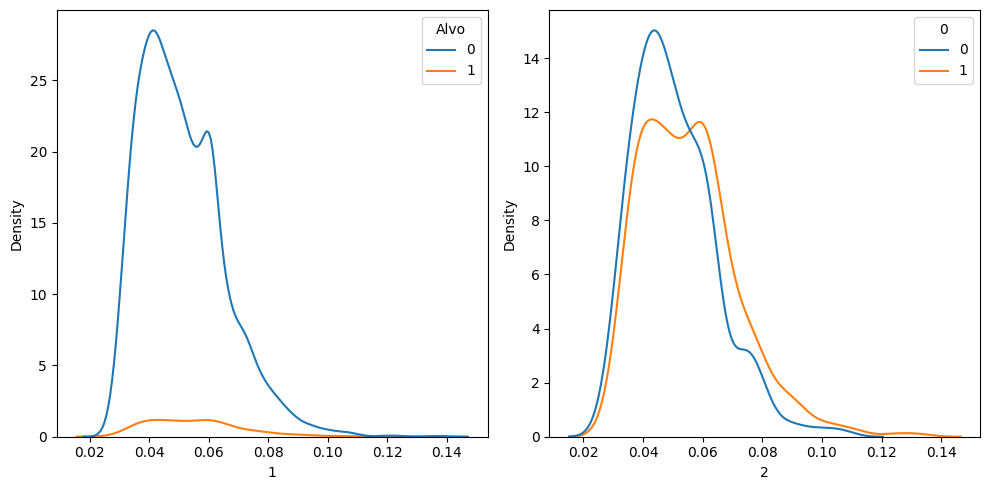

In [90]:
#Instancio o objeto de undersampling para fazer ajuste de patamar nas distribuicoes
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

#Gero as bases com as probabilidades para cada classe
output = pd.DataFrame(y_test.values).rename(columns={0: "Alvo"}).join(pd.DataFrame(Model_grid.best_estimator_.predict_proba(X_test)), how="left")
X_resampled, y_X_resampled = rus.fit_resample(  output.values , pd.DataFrame(output)['Alvo'].values )
print('Resampled dataset shape %s' % Counter(y_X_resampled))

#Gero plot para avaliar a diferenca de distribuicao entre as classes, isso ajuda a encontrar um limiar e avalair a qualidade do classificador 
fig, axes = plt.subplots(1,2, figsize=(10,5))

#Plot da base teste original
sns. kdeplot(output, x=1, hue="Alvo" , ax = axes[0])
#Plot com a base teste com a classe majoritaria reduzida
sns. kdeplot( pd.DataFrame(y_X_resampled), x=pd.DataFrame(X_resampled)[2], hue=0,  ax = axes[1])

plt.tight_layout()
plt.show()

In [91]:
#Gera insumos para avaliar a sensibilidade por limiares diversos

prob = pd.DataFrame(Model_grid.best_estimator_.predict_proba(X_test))
recall = []

for n in np.arange(0.01,0.99,0.01):
    prob['y_pred'] = prob[1].apply(lambda x: 1 if x > n else 0)
    recall.append( recall_score(y_test, prob['y_pred'] ) )

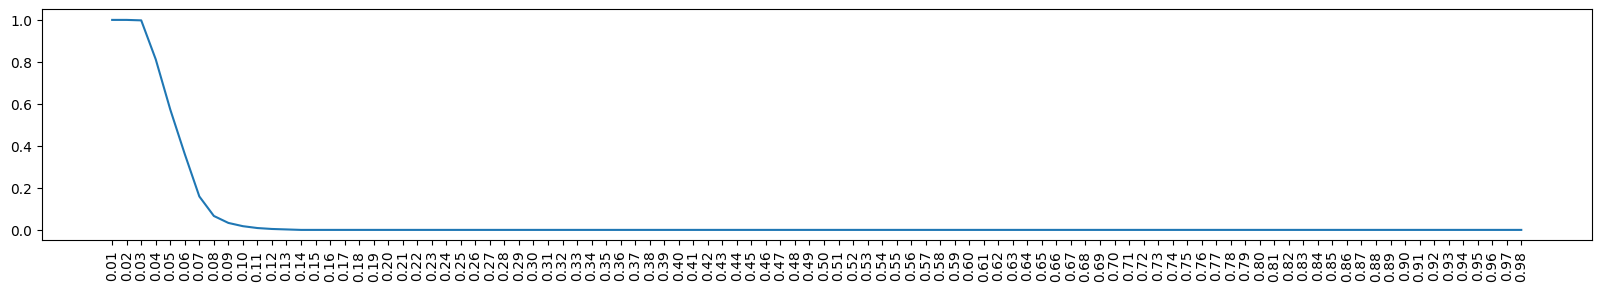

In [92]:
#Plot sensibilidade por limiares e identificar ponto otimo.
fig, ax = plt.subplots(1,1 ,figsize=(20,3)) 
plt.plot(np.arange(0.01,0.99,0.01), recall)
plt.xticks( np.arange(0.01,0.99,0.01) ) 
plt.xticks(rotation=90)
plt.show()

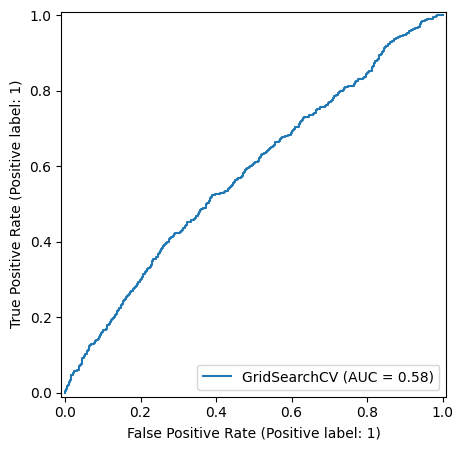

In [93]:
#Curva ROC
fig, ax = plt.subplots(1,1 ,figsize=(10,5)) 
RocCurveDisplay.from_estimator(  Model_grid, X_test, y_test, ax=ax)
plt.show()

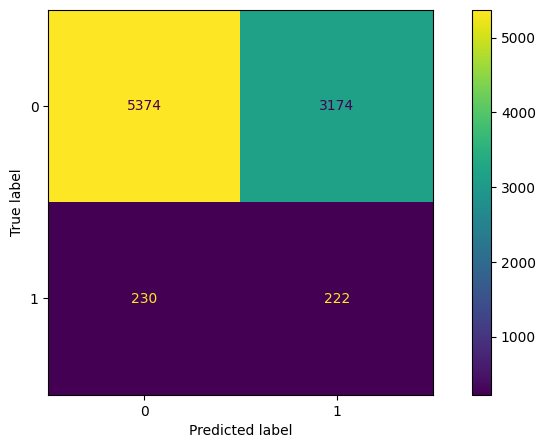

In [95]:
#Matriz de confusao
fig, ax = plt.subplots(1,1 ,figsize=(10,5)) 

predictions = Model_grid.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=Model_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = Model_grid.classes_)

disp.plot(ax=ax)
plt.show()

In [96]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=Model_grid.classes_).ravel() 
(tn, fp, fn, tp)

(np.int64(5374), np.int64(3174), np.int64(230), np.int64(222))

-----------------------------------

### Random Forest Classifier

In [351]:
X_train, X_test, y_train, y_test = train_test_split( scaler.fit_transform(X), y, test_size=0.30, random_state=42, stratify = y)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( df_pca, y, test_size=0.30, random_state=42, stratify = y)
X_train_GA, X_test_GA, y_train_GA, y_test_GA = train_test_split( scaler.fit_transform(X[listGA]), y, test_size=0.30, random_state=42, stratify = y)
X_train_SFS, X_test_SFS, y_train_SFS, y_test_SFS = train_test_split( scaler.fit_transform(X[listSFS]), y, test_size=0.30, random_state=42, stratify = y)

In [352]:
from sklearn.ensemble import RandomForestClassifier

In [361]:
#Medidas para avaliar no GridSearch
scoring = ['accuracy', 'precision', 'recall', 'f1' , 'roc_auc']

param_grid = {#'bootstrap': [True, False], 
 'max_depth': [10, 50,  100], #None
 #'max_features': ['sqrt', 'log2', None],
# 'min_samples_leaf': [1, 2, 4],
 #'min_samples_split': [2, 5, 10],
 'n_estimators': [ 500, 1000, 2000],
 'class_weight': ['balanced'],
#'ccp_alpha': [0, .3, .6 ]
}

Model_grid = GridSearchCV( estimator=RandomForestClassifier(), param_grid = param_grid , verbose=10, cv=2, n_jobs=-2, return_train_score = True, 
                          scoring = scoring, refit = 'f1')

In [362]:
now = datetime.datetime.now()
print(now.time())

Model_grid.fit(X_train, y_train )
model2 = deepcopy(Model_grid)

print(Model_grid.score(X_test,y_test) )
print(Model_grid.best_estimator_)
#cache_size
Model_grid_results = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results.insert(0, "df_Feature", 'Original', True)
best_grid = Model_grid.best_params_ 
model_predict = Model_grid.best_estimator_

now = datetime.datetime.now()
print(now.time())

15:16:01.417122
Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.12004287245444802
RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=2000)
15:17:30.929025


In [363]:
Model_grid.cv_results_

{'mean_fit_time': array([ 6.40681243, 12.51936626, 24.69034159,  8.71274722, 17.39824224,
        31.76027143,  8.67624748, 16.36824036, 26.59491467]),
 'std_fit_time': array([0.04988742, 0.01584983, 0.18112004, 0.01624882, 0.14094496,
        1.23966348, 0.25509536, 0.26477408, 0.58025289]),
 'mean_score_time': array([1.08021748, 2.17538905, 3.8687309 , 1.58048189, 3.15189493,
        4.58590806, 1.6211431 , 2.57520914, 4.1517266 ]),
 'std_score_time': array([9.21356678e-03, 7.54117966e-04, 1.61278248e-03, 9.60743427e-03,
        1.54972076e-06, 1.73407435e-01, 4.91142273e-05, 1.96964025e-01,
        2.90397406e-02]),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced',
                    'balanced'],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_max_depth

In [364]:
Model_grid.fit(X_train_pca, y_train_pca )

print(Model_grid.score(X_test_pca, y_test_pca) )
print(Model_grid.best_estimator_)

Model_grid_results_pca = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_pca.insert(0, "df_Feature", 'PCA', True)
best_grid_pca = Model_grid.best_params_ 

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.06596306068601583
RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=1000)


In [365]:
Model_grid.fit(X_train_GA, y_train_GA )

print(Model_grid.score(X_test_GA,y_test_GA) )
print(Model_grid.best_estimator_)

Model_grid_results_GA = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_GA.insert(0, "df_Feature", 'GA', True)
best_grid_GA = Model_grid.best_params_ 

Fitting 2 folds for each of 9 candidates, totalling 18 fits


C:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.13535353535353536
RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500)


In [366]:
Model_grid.fit(X_train_SFS, y_train_SFS )

print(Model_grid.score(X_test_SFS,y_test_SFS) )
print(Model_grid.best_estimator_)

Model_grid_results_SFS = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_SFS.insert(0, "df_Feature", 'SFS', True)
best_grid_SFS = Model_grid.best_params_ 

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.08172362555720654
RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500)


In [367]:
#grid_list = {0: "Alvo", }   rename(columns={0: "Alvo"})
#df.style.format({"B": lambda x: "±{:.2f}".format(abs(x))})
metrics_column = ['df_Feature', 'mean_test_accuracy','std_test_accuracy', 'mean_test_precision','std_test_precision', 'mean_test_recall','std_test_recall', 'mean_test_f1','std_test_f1', 'mean_test_roc_auc','std_test_roc_auc']
res = Model_grid_results.loc[ Model_grid_results["params"] == best_grid  ][metrics_column]#.style.format('{:.2%}')
res_pca = Model_grid_results_pca.loc[ Model_grid_results_pca["params"] == best_grid_pca  ][metrics_column]#.style.format('{:.2%}')
res_GA = Model_grid_results_GA.loc[ Model_grid_results_GA["params"] == best_grid_GA  ][metrics_column]#.style.format('{:.2%}')
res_SFS = Model_grid_results_SFS.loc[ Model_grid_results_SFS["params"] == best_grid_SFS  ][metrics_column]#.style.format('{:.2%}')

Resultado_RForest = pd.concat([res, res_pca, res_GA, res_SFS])#.style.format('{:.2}')
Resultado_RForest

,df_Feature,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc
2,Original,0.929000,0.010429,0.167495,0.055856,0.086253,0.002762,0.110299,0.011248,0.579132,0.006268
1,PCA,0.940762,0.000667,0.109996,0.040689,0.027502,0.014244,0.043818,0.021561,0.554322,0.004872
0,GA,0.924952,0.010381,0.159655,0.033894,0.104253,0.013171,0.122660,0.001211,0.574834,0.004747
0,SFS,0.897429,0.023714,0.083263,0.021724,0.090981,0.015080,0.082996,0.005110,0.542444,0.007818


Resampled dataset shape Counter({np.int64(0): 10218, np.int64(1): 10218})


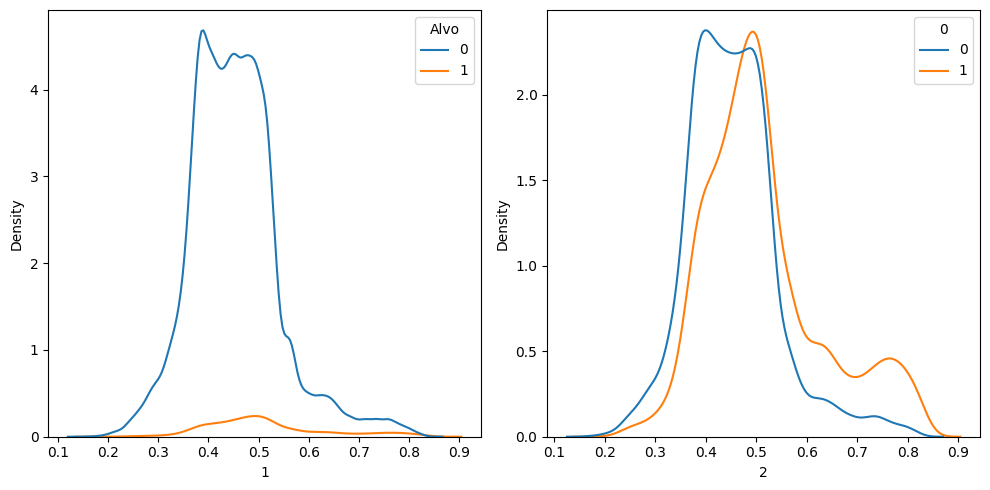

In [135]:
#Instancio o objeto de undersampling para fazer ajuste de patamar nas distribuicoes
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

#Gero as bases com as probabilidades para cada classe
output = pd.DataFrame(y_test.values).rename(columns={0: "Alvo"}).join(pd.DataFrame(model_predict.predict_proba(X_test)), how="left")
X_resampled, y_X_resampled = rus.fit_resample(  output.values , pd.DataFrame(output)['Alvo'].values )
print('Resampled dataset shape %s' % Counter(y_X_resampled))

#Gero plot para avaliar a diferenca de distribuicao entre as classes, isso ajuda a encontrar um limiar e avalair a qualidade do classificador 
fig, axes = plt.subplots(1,2, figsize=(10,5))

#Plot da base teste original
sns. kdeplot(output, x=1, hue="Alvo" , ax = axes[0])
#Plot com a base teste com a classe majoritaria reduzida
sns. kdeplot( pd.DataFrame(y_X_resampled), x=pd.DataFrame(X_resampled)[2], hue=0,  ax = axes[1])

plt.tight_layout()
plt.show()

In [138]:
#Gera insumos para avaliar a sensibilidade por limiares diversos

prob = pd.DataFrame( model_predict.predict_proba(X_test))
recall = []

for n in np.arange(0.01,0.99,0.01):
    prob['y_pred'] = prob[1].apply(lambda x: 1 if x > n else 0)
    recall.append( recall_score(y_test, prob['y_pred'] ) )

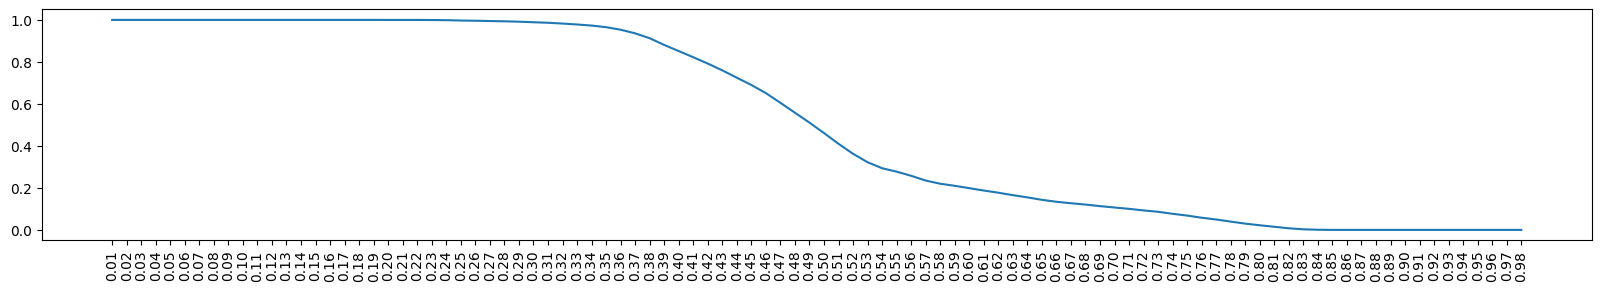

In [139]:
#Plot sensibilidade por limiares e identificar ponto otimo.
fig, ax = plt.subplots(1,1 ,figsize=(20,3)) 
plt.plot(np.arange(0.01,0.99,0.01), recall)
plt.xticks( np.arange(0.01,0.99,0.01) ) 
plt.xticks(rotation=90)
plt.show()

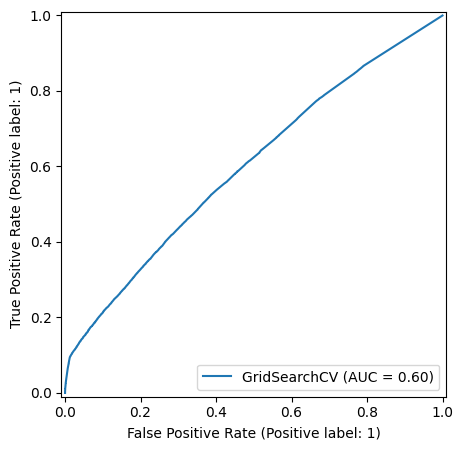

In [144]:
#Curva ROC
fig, ax = plt.subplots(1,1 ,figsize=(10,5)) 
RocCurveDisplay.from_estimator(  Model_grid, X_test_SFS, y_test_SFS, ax=ax)
plt.show()

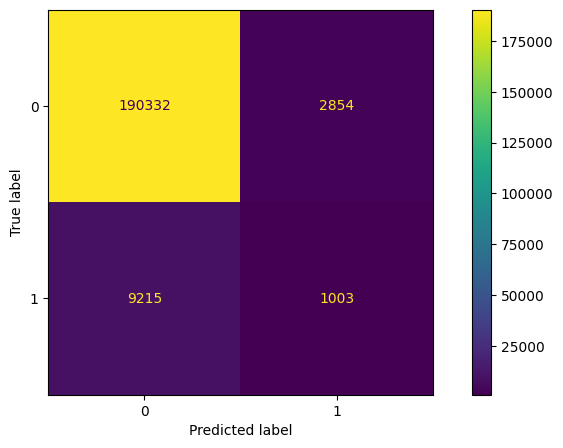

In [146]:
#Matriz de confusao
fig, ax = plt.subplots(1,1 ,figsize=(10,5)) 

predictions = Model_grid.predict(X_test_SFS)
cm = confusion_matrix( y_test_SFS, predictions, labels=Model_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = Model_grid.classes_)

disp.plot(ax=ax)
plt.show()

In [147]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=Model_grid.classes_).ravel() 
(tn, fp, fn, tp)

(np.int64(190332), np.int64(2854), np.int64(9215), np.int64(1003))

-------------------------------------------------------------

### Rede Neural Perceptron Multicamadas

In [15]:
from sklearn.neural_network import MLPClassifier 

In [237]:
X_train, X_test, y_train, y_test = train_test_split(  scaler.fit_transform(X), y, test_size=0.20, random_state=42, stratify = y)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( df_pca, y, test_size=0.20, random_state=42, stratify = y)
X_train_GA, X_test_GA, y_train_GA, y_test_GA = train_test_split( scaler.fit_transform(X[listGA]), y, test_size=0.20, random_state=42, stratify = y)
X_train_SFS, X_test_SFS, y_train_SFS, y_test_SFS = train_test_split( scaler.fit_transform(X[listSFS]), y, test_size=0.20, random_state=42, stratify = y)

In [238]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)

X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
df_pca_res,  y_pca_res = smt.fit_resample( X_train_pca, y_train_pca )
X_train_GA_res, y_train_GA_res = smt.fit_resample(X_train_GA, y_train_GA)
X_train_SFS_res, y_train_SFS_res = smt.fit_resample(X_train_SFS, y_train_SFS)

print('Resampled dataset shape %s' % Counter(y_train_res))

Resampled dataset shape Counter({0: 510811, 1: 510811})


In [309]:
#Medidas para avaliar no GridSearch
scoring = ['accuracy', 'precision', 'recall', 'f1' , 'roc_auc']

param_grid = {
'hidden_layer_sizes':[ 2, 5, 10 ],
#'hidden_layer_sizes': [400,1000],#, 500, 1000,1500, 2000, 4000,6000,10000], 
'activation':  [  'relu' ], # [ 'logistic', 'identity', 'logistic', 'tanh', 'relu'], 
'solver':['sgd'],
 #'momentum':[0.1, 0.5, 0.8] ,
'alpha':[0.1], #L2 Regulazrizador 0.0001
'learning_rate_init':[ 0.1, 0.05, 0.01],
'max_iter' : [1000],
'batch_size': [2000], #895888
#  'learning_rate' :['constant', 'invscaling', 'adaptive'}, 
#  'tol': [ 0.00001],# 0.0001
'shuffle': [True] #Para embaralhar as instancias do lote
}

Model_grid = GridSearchCV( estimator=MLPClassifier(), param_grid = param_grid , verbose=10, cv=2, n_jobs=-2, return_train_score = True, 
                          scoring = scoring, refit = 'f1')

In [310]:
now = datetime.datetime.now()
print(now.time())

Model_grid.fit(X_train_res, y_train_res )   
#model2 = deepcopy(Model_grid)

print(Model_grid.score(X_test, y_test) )
print(Model_grid.best_estimator_)
#cache_size
Model_grid_results = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results.insert(0, "df_Feature", 'Original', True)
best_grid = Model_grid.best_params_ 
model_predict = Model_grid.best_estimator_

now = datetime.datetime.now()
print(now.time())

00:09:49.120619
Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.12636411530066982
MLPClassifier(alpha=0.1, batch_size=2000, hidden_layer_sizes=10,
              learning_rate_init=0.1, max_iter=1000, solver='sgd')
00:10:46.596556


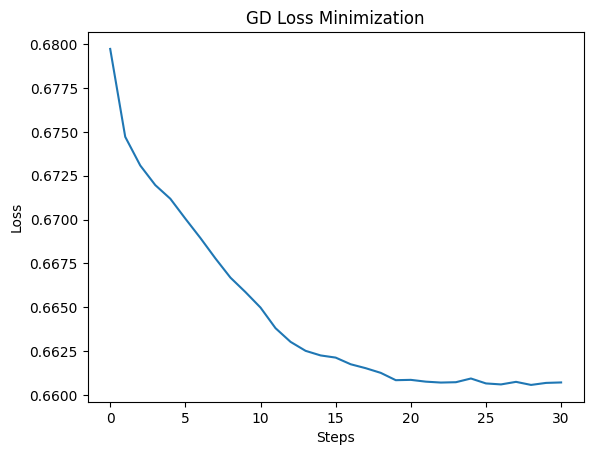

In [311]:
def plot_loss(model):
    plt.plot(model.best_estimator_.loss_curve_)
    plt.title('GD Loss Minimization')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    
plot_loss(Model_grid)

In [312]:
Model_grid.cv_results_

{'mean_fit_time': array([ 6.28085864,  8.3983984 , 13.88176298, 14.23010695, 23.67422855,
        16.85908532, 21.65287256, 24.77797711, 13.95670462]),
 'std_fit_time': array([0.48874772, 0.19000077, 1.60226607, 1.71792996, 0.29449975,
        0.91411662, 5.65776992, 3.13805234, 0.74059868]),
 'mean_score_time': array([0.75577986, 0.88402927, 0.83494937, 0.93168998, 0.74676335,
        0.88451576, 0.57001221, 0.49723542, 0.57485056]),
 'std_score_time': array([0.05529082, 0.0056926 , 0.01036608, 0.04626203, 0.01489151,
        0.13321996, 0.12085402, 0.06616676, 0.00407219]),
 'param_activation': masked_array(data=['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu',
                    'relu', 'relu'],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_alpha': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, Fals

In [315]:
Model_grid.fit( df_pca_res,  y_pca_res  )

print(Model_grid.score(X_test_pca, y_test_pca) )
print(Model_grid.best_estimator_)

Model_grid_results_pca = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_pca.insert(0, "df_Feature", 'PCA', True)
best_grid_pca = Model_grid.best_params_ 

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.12947658402203857
MLPClassifier(alpha=0.1, batch_size=2000, hidden_layer_sizes=10,
              learning_rate_init=0.1, max_iter=1000, solver='sgd')


In [316]:
Model_grid.fit( X_train_GA_res, y_train_GA_res   )

print(Model_grid.score(X_test_GA,y_test_GA) )
print(Model_grid.best_estimator_)

Model_grid_results_GA = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_GA.insert(0, "df_Feature", 'GA', True)
best_grid_GA = Model_grid.best_params_ 

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.11384392517478113
MLPClassifier(alpha=0.1, batch_size=2000, hidden_layer_sizes=2,
              learning_rate_init=0.1, max_iter=1000, solver='sgd')


In [317]:
Model_grid.fit( X_train_SFS_res, y_train_SFS_res  )

print(Model_grid.score( X_test_SFS,y_test_SFS) )
print(Model_grid.best_estimator_)

Model_grid_results_SFS = pd.DataFrame(Model_grid.cv_results_)
Model_grid_results_SFS.insert(0, "df_Feature", 'SFS', True)
best_grid_SFS = Model_grid.best_params_ 

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.0973033950580244
MLPClassifier(alpha=0.1, batch_size=2000, hidden_layer_sizes=2,
              learning_rate_init=0.01, max_iter=1000, solver='sgd')


In [325]:
#grid_list = {0: "Alvo", }   rename(columns={0: "Alvo"})
#df.style.format({"B": lambda x: "±{:.2f}".format(abs(x))})
metrics_column = ['df_Feature', 'mean_test_accuracy','std_test_accuracy', 'mean_test_precision','std_test_precision', 'mean_test_recall','std_test_recall', 'mean_test_f1','std_test_f1', 'mean_test_roc_auc','std_test_roc_auc']
res = Model_grid_results.loc[ Model_grid_results["params"] == best_grid  ][metrics_column]#.style.format('{:.2%}')
res_pca = Model_grid_results_pca.loc[ Model_grid_results_pca["params"] == best_grid_pca  ][metrics_column]#.style.format('{:.2%}')
res_GA = Model_grid_results_GA.loc[ Model_grid_results_GA["params"] == best_grid_GA  ][metrics_column]#.style.format('{:.2%}')
res_SFS = Model_grid_results_SFS.loc[ Model_grid_results_SFS["params"] == best_grid_SFS  ][metrics_column]#.style.format('{:.2%}')

Resultado_dnn = pd.concat([res, res_pca, res_GA, res_SFS])#.style.format('{:.2}')
Resultado_dnn

,df_Feature,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc
6,Original,0.596201,0.004626,0.590872,0.004367,0.625523,0.004637,0.607704,0.004498,0.641030,0.006277
6,PCA,0.572833,0.001102,0.576711,0.006185,0.551246,0.046857,0.562398,0.021590,0.608837,0.001880
0,GA,0.556780,0.003888,0.552614,0.012725,0.620409,0.095475,0.579971,0.035583,0.583026,0.005632
2,SFS,0.525693,0.000563,0.522311,0.004991,0.634779,0.149465,0.564425,0.058987,0.530422,0.000382


Resampled dataset shape Counter({np.int64(0): 6812, np.int64(1): 6812})


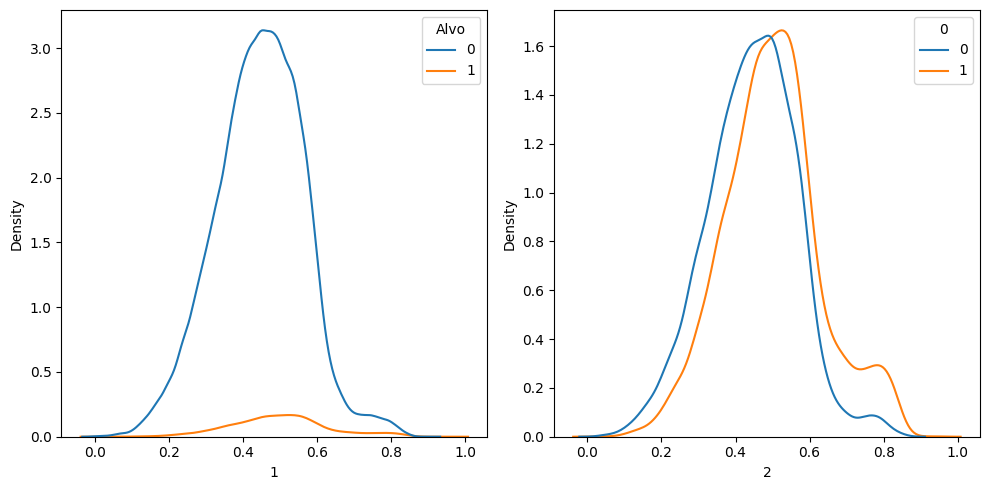

In [319]:
#Instancio o objeto de undersampling para fazer ajuste de patamar nas distribuicoes
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

#Gero as bases com as probabilidades para cada classe
output = pd.DataFrame(y_test.values).rename(columns={0: "Alvo"}).join(pd.DataFrame(model_predict.predict_proba(X_test)), how="left")
X_resampled, y_X_resampled = rus.fit_resample(  output.values , pd.DataFrame(output)['Alvo'].values )
print('Resampled dataset shape %s' % Counter(y_X_resampled))

#Gero plot para avaliar a diferenca de distribuicao entre as classes, isso ajuda a encontrar um limiar e avalair a qualidade do classificador 
fig, axes = plt.subplots(1,2, figsize=(10,5))

#Plot da base teste original
sns. kdeplot(output, x=1, hue="Alvo" , ax = axes[0])
#Plot com a base teste com a classe majoritaria reduzida
sns. kdeplot( pd.DataFrame(y_X_resampled), x=pd.DataFrame(X_resampled)[2], hue=0,  ax = axes[1])

plt.tight_layout()
plt.show()

In [320]:
#Gera insumos para avaliar a sensibilidade por limiares diversos

prob = pd.DataFrame( model_predict.predict_proba(X_test))
recall = []

for n in np.arange(0.01,0.99,0.01):
    prob['y_pred'] = prob[1].apply(lambda x: 1 if x > n else 0)
    recall.append( recall_score(y_test, prob['y_pred'] ) )

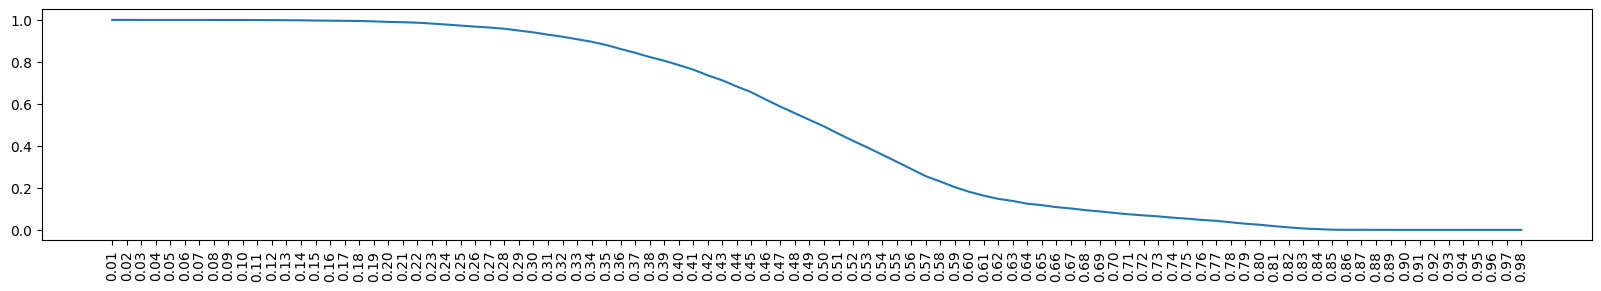

In [321]:
#Plot sensibilidade por limiares e identificar ponto otimo.
fig, ax = plt.subplots(1,1 ,figsize=(20,3)) 
plt.plot(np.arange(0.01,0.99,0.01), recall)
plt.xticks( np.arange(0.01,0.99,0.01) ) 
plt.xticks(rotation=90)
plt.show()

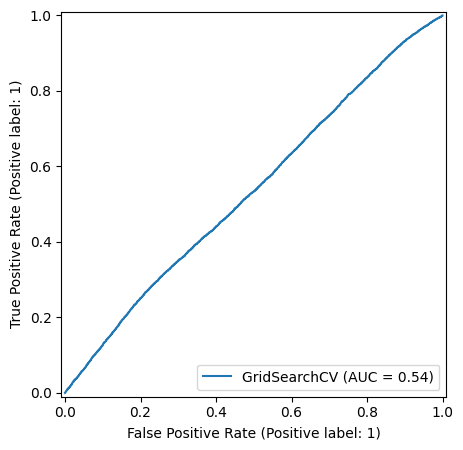

In [322]:
#Curva ROC
fig, ax = plt.subplots(1,1 ,figsize=(10,5)) 
RocCurveDisplay.from_estimator(  Model_grid, X_test_SFS, y_test_SFS, ax=ax)
plt.show()

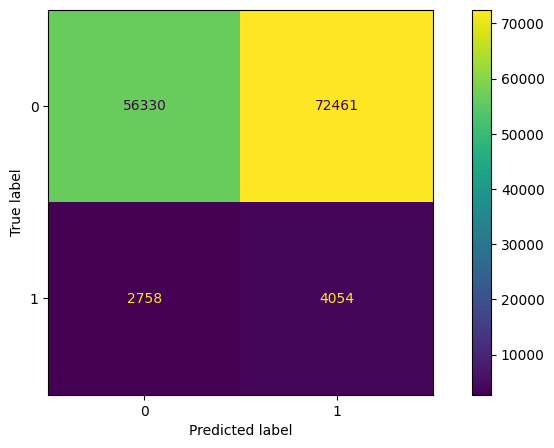

In [323]:
#Matriz de confusao
fig, ax = plt.subplots(1,1 ,figsize=(10,5)) 

predictions = Model_grid.predict(X_test_SFS)
cm = confusion_matrix( y_test_SFS, predictions, labels=Model_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = Model_grid.classes_)

disp.plot(ax=ax)
plt.show()

In [324]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=Model_grid.classes_).ravel() 
(tn, fp, fn, tp)

(np.int64(56330), np.int64(72461), np.int64(2758), np.int64(4054))

#### Keras - testando ideias 

In [313]:
import keras
print(keras.__version__)

3.6.0


In [314]:
X_train, X_val, y_train, y_val = train_test_split( X_train_res, y_train_res, test_size=0.20, random_state=42, stratify = y_train_res)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split( df_pca_res,  y_pca_res, test_size=0.20, random_state=42, stratify = y_pca_res)
X_train_GA, X_val_GA, y_train_GA, y_val_GA = train_test_split( X_train_GA_res, y_train_GA_res, test_size=0.20, random_state=42, stratify = y_train_GA_res)
X_train_SFS, X_val_SFS, y_train_SFS, y_val_SFS = train_test_split( X_train_SFS_res, y_train_SFS_res, test_size=0.20, random_state=42, stratify = y_train_SFS_res)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [136]:
model = keras.Sequential(
    [
        keras.Input(shape=(9,) ),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 100)                 │           1,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,101 (4.30 KB)

 Trainable params: 1,101 (4.30 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
def f1_weighted(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    #predLabels = K.argmax(pred, axis=-1)
    #pred = K.one_hot(predLabels, 4) 


    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
        #all with shape (4,)
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)

    
    return  1 - weighted_f1 #for metrics, return only 'weighted_f1' -- 1 - weighted_f1

In [85]:
counts = np.bincount(y.values[:])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y.values)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight2 = {0: weight_for_0, 1: weight_for_1}
class_weight2

Number of positive samples in training data: 34060 (5.02% of total)


{0: np.float64(1.5529083644303233e-06), 1: np.float64(2.935995302407516e-05)}

In [137]:
from sklearn.utils.class_weight import compute_class_weight

metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    #keras.metrics.F1Score(average=None, threshold=0.5, name="f1_score", dtype=None),
    #keras.metrics.FBetaScore(name="F1"),
    #f1_m,
    keras.metrics.AUC(name="AUC"),
    keras.metrics.BinaryAccuracy(name='Accuracy'),
]

class_weights = dict(enumerate( compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y) ))
class_weights

{0: np.float64(0.5264460294462484), 1: np.float64(9.953214914856137)}

In [138]:
import tensorflow.keras.backend as K
#model.compile(loss=f1_weighted, optimizer='adam', metrics=metrics) # keras.losses.BinaryCrossentropy()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=metrics) # 

In [140]:
model.fit( scaler.fit_transform(X_train), y_train.values, epochs=100, batch_size=20000,  validation_data=(scaler.fit_transform(X_val), y_val.values), verbose=2, class_weight = peso ) # =peso,

Epoch 1/100
36/36 - 1s - 16ms/step - AUC: 0.7953 - Accuracy: 0.6601 - fn: 56372.0000 - fp: 187217.0000 - loss: 0.7271 - precision: 0.6173 - recall: 0.8427 - tn: 171138.0000 - tp: 301983.0000 - val_AUC: 0.7936 - val_Accuracy: 0.6684 - val_fn: 17770.0000 - val_fp: 41650.0000 - val_loss: 0.5389 - val_precision: 0.6329 - val_recall: 0.8016 - val_tn: 47939.0000 - val_tp: 71819.0000
Epoch 2/100
36/36 - 1s - 15ms/step - AUC: 0.7957 - Accuracy: 0.6608 - fn: 56413.0000 - fp: 186725.0000 - loss: 0.7267 - precision: 0.6179 - recall: 0.8426 - tn: 171630.0000 - tp: 301942.0000 - val_AUC: 0.7866 - val_Accuracy: 0.6644 - val_fn: 19085.0000 - val_fp: 41043.0000 - val_loss: 0.5464 - val_precision: 0.6321 - val_recall: 0.7870 - val_tn: 48546.0000 - val_tp: 70504.0000
Epoch 3/100
36/36 - 1s - 15ms/step - AUC: 0.7957 - Accuracy: 0.6596 - fn: 56104.0000 - fp: 187879.0000 - loss: 0.7265 - precision: 0.6167 - recall: 0.8434 - tn: 170476.0000 - tp: 302251.0000 - val_AUC: 0.7883 - val_Accuracy: 0.6677 - val_fn

In [ ]:
model.evaluate(X_test,y_test)

In [36]:
pred = model.predict( scaler.fit_transform(X) )
#y.shape

21188/21188 ━━━━━━━━━━━━━━━━━━━━ 18s 850us/step


-----------------------------------------------

## Quadros comparativos - Tecnicas x Datasets

In [466]:
#Acuracia
#Media
a = Resultado_dnn[['df_Feature','mean_test_accuracy']].rename(columns={"mean_test_accuracy": "DNN" })
b = Resultado_svm[['df_Feature','mean_test_accuracy']].rename(columns={"mean_test_accuracy": "SVM" })
c = Resultado_RForest[['df_Feature','mean_test_accuracy']].rename(columns={"mean_test_accuracy": "RForest" })
d = Resultado_bayes[['df_Feature','mean_test_accuracy']].rename(columns={"mean_test_accuracy": "NBayes" })

#Devio Padrao
e = Resultado_dnn[['df_Feature','std_test_accuracy']].rename(columns={"std_test_accuracy": "DNN" })
f = Resultado_svm[['df_Feature','std_test_accuracy']].rename(columns={"std_test_accuracy": "SVM" })
g = Resultado_RForest[['df_Feature','std_test_accuracy']].rename(columns={"std_test_accuracy": "RForest" })
h = Resultado_bayes[['df_Feature','std_test_accuracy']].rename(columns={"std_test_accuracy": "NBayes" })


Accuracy_Mean = a.merge(b, how='inner', on='df_Feature').merge(c, how='inner', on='df_Feature').merge(d, how='inner', on='df_Feature')
Accuracy_std = e.merge(f, how='inner', on='df_Feature').merge(g, how='inner', on='df_Feature').merge(h, how='inner', on='df_Feature')

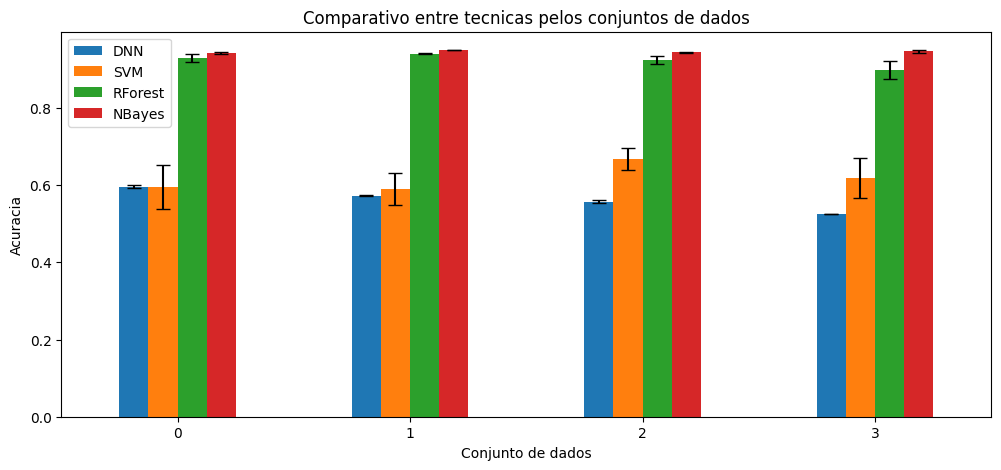

In [477]:
fig, ax = plt.subplots(1,1 ,figsize=(12,5)) 
Accuracy_Mean.plot.bar(yerr = Accuracy_std , ax=ax, capsize=5 )

plt.xticks(rotation=0)
plt.ylabel('Acuracia')
plt.xlabel('Conjunto de dados')
plt.title('Comparativo entre tecnicas pelos conjuntos de dados')
plt.show()

In [468]:
#Precisao

#Media
a = Resultado_dnn[['df_Feature','mean_test_precision']].rename(columns={"mean_test_precision": "DNN" })
b = Resultado_svm[['df_Feature','mean_test_precision']].rename(columns={"mean_test_precision": "SVM" })
c = Resultado_RForest[['df_Feature','mean_test_precision']].rename(columns={"mean_test_precision": "RForest" })
d = Resultado_bayes[['df_Feature','mean_test_precision']].rename(columns={"mean_test_precision": "NBayes" })

#Devio Padrao
e = Resultado_dnn[['df_Feature','std_test_precision']].rename(columns={"std_test_precision": "DNN" })
f = Resultado_svm[['df_Feature','std_test_precision']].rename(columns={"std_test_precision": "SVM" })
g = Resultado_RForest[['df_Feature','std_test_precision']].rename(columns={"std_test_precision": "RForest" })
h = Resultado_bayes[['df_Feature','std_test_precision']].rename(columns={"std_test_precision": "NBayes" })


precision_Mean = a.merge(b, how='inner', on='df_Feature').merge(c, how='inner', on='df_Feature').merge(d, how='inner', on='df_Feature')
precision_std = e.merge(f, how='inner', on='df_Feature').merge(g, how='inner', on='df_Feature').merge(h, how='inner', on='df_Feature')

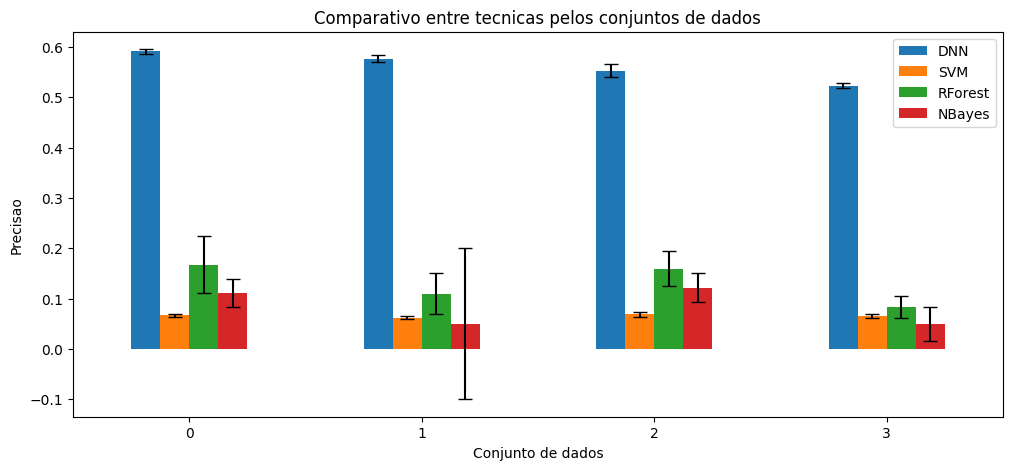

In [478]:
fig, ax = plt.subplots(1,1 ,figsize=(12,5)) 
precision_Mean.plot.bar(yerr = precision_std , ax=ax, capsize=5 )

plt.xticks(rotation=0)
plt.ylabel('Precisao')
plt.xlabel('Conjunto de dados')
plt.title('Comparativo entre tecnicas pelos conjuntos de dados')
plt.show()

In [483]:
#F1

#Media
a = Resultado_dnn[['df_Feature','mean_test_f1']].rename(columns={"mean_test_f1": "DNN" })
b = Resultado_svm[['df_Feature','mean_test_f1']].rename(columns={"mean_test_f1": "SVM" })
c = Resultado_RForest[['df_Feature','mean_test_f1']].rename(columns={"mean_test_f1": "RForest" })
d = Resultado_bayes[['df_Feature','mean_test_f1']].rename(columns={"mean_test_f1": "NBayes" })

#Devio Padrao
e = Resultado_dnn[['df_Feature','std_test_f1']].rename(columns={"std_test_f1": "DNN" })
f = Resultado_svm[['df_Feature','std_test_f1']].rename(columns={"std_test_f1": "SVM" })
g = Resultado_RForest[['df_Feature','std_test_f1']].rename(columns={"std_test_f1": "RForest" })
h = Resultado_bayes[['df_Feature','std_test_f1']].rename(columns={"std_test_f1": "NBayes" })

F1_Mean = a.merge(b, how='inner', on='df_Feature').merge(c, how='inner', on='df_Feature').merge(d, how='inner', on='df_Feature')
F1_std = e.merge(f, how='inner', on='df_Feature').merge(g, how='inner', on='df_Feature').merge(h, how='inner', on='df_Feature')

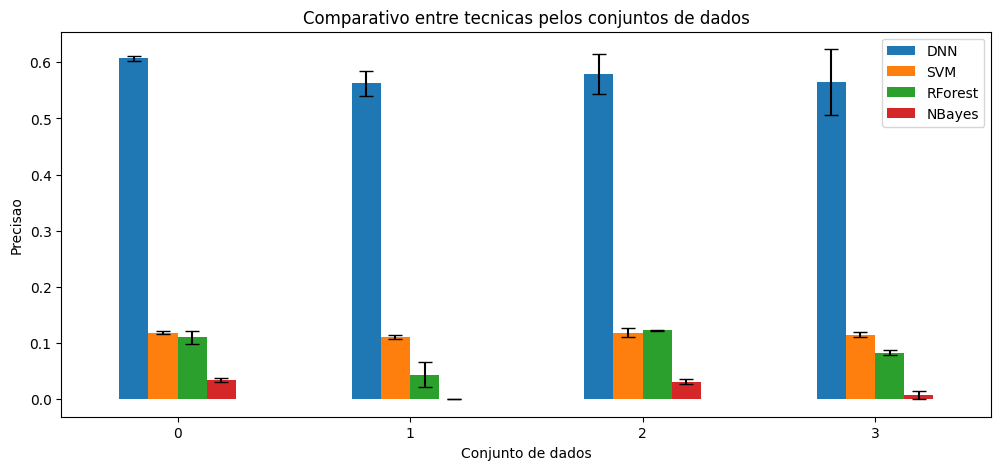

In [484]:
fig, ax = plt.subplots(1,1 ,figsize=(12,5)) 
F1_Mean.plot.bar(yerr = F1_std , ax=ax, capsize=5 )

plt.xticks(rotation=0)
plt.ylabel('Precisao')
plt.xlabel('Conjunto de dados')
plt.title('Comparativo entre tecnicas pelos conjuntos de dados')
plt.show()